In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import time
import pycbc.conversions as conv
import corner

from gwbench import injections
from gwbench import network
from gwbench import snr

from numba import njit

In [51]:
save_likelihoods = False

plotdir = 'power_law_smooth_hyper_param_plots/'

likelihood_dir = 'power_law_smooth_likelihoods/'

alpha_inj = -3.5 # slope of m1
beta_inj = 0.0 # slope of m2
mmin_inj = 5.0 # low-mass peak of mass distribution
m_min_lim_inj = 3.0 # minimum allowed mass
eta_inj = 50.0 # butterworth smoothing param
mmax_inj = 60. # maximum allowed mass

bias_index=1

import matplotlib
# font = {'family' : 'serif',
#         'size'   : 16}

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 24
})

# Read simulation

In [45]:
# File with Mc biases
# files = ['powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_Mc_0_9600.csv']#, 
        #  'powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_Mc_2400_4800.csv', 
        #  'powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_Mc_4800_7200.csv',
        #  'powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_Mc_7200_9600.csv']

files = ['powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_0_9600_Voyager.csv']

df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
df_mc_raw = df_mc_raw[(df_mc_raw["m1"]/(1+df_mc_raw["z"])) <= 60.]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))


Total number of events: 9600


In [46]:
np.sum(df_mc_raw["z_full_bias"]<0)

193

In [47]:
# File with eta biases

# files = ['powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_eta_0_9600.csv']#, 
        #  'powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_eta_2400_4800.csv', 
        #  'powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_eta_4800_7200.csv',
        #  'powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_lam_0_1_eta_7200_9600.csv']

files = ['powerlaw_3.5_lams_smooth/powerlaw_alpha_3.5_0_9600_Voyager.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
df_eta_raw = df_eta_raw[(df_eta_raw["m1"]/(1+df_eta_raw["z"])) <= 60.]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 9600


## Sample from the events if needed

In [48]:
# # Select random subset of the data
# n_samples = 1200
# sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
# df_mc = df_mc_raw.iloc[sample_indices]
# df_eta = df_eta_raw.iloc[sample_indices]

# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

print(len(df_mc))
print(np.median(df_mc["Mc"]))

9600
18.24713002798325


In [49]:
df_mc.reset_index(inplace = True,drop = True)
# df_eta.reset_index(inplace = True,drop = True)

$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

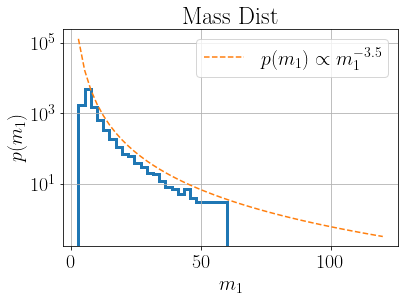

In [52]:
bins = np.linspace(3, 120, 50)

m1_inj = df_mc["m1"]/(1+df_mc["z"])
# y, X = np.histogram(m1_inj, bins=bins, density=True)
# X = X[:-1]
# plt.plot(X, y, 'bo', label='Injected')

plt.hist(m1_inj, bins, histtype='step', lw=3)
plt.plot(bins, 6000000*bins**(alpha_inj), linestyle='--', label='$p(m_1) \propto m_1^{-3.5}$')
plt.grid()
plt.semilogy()

plt.xlabel("$m_1$")
plt.ylabel("$p(m_1)$")
plt.title("Mass Dist")
plt.legend()

# plt.xlim(3, 7)

# plt.savefig("powerlaw_3.5_plots/powerlaw_m1_dist.pdf")
plt.show()

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) + log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s + \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [10]:
def sample_m1_m2_events(df_mc, df_eta, biased=False, bias_index=19, injected=True):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m1_mu_detections = df_mc["m1"] / (1+z)
    m2_mu_detections = df_mc["m2"] / (1+z)

    # compute variance of m1
    aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
    aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
    m1_variance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))
    m1_variance = m1_variance.values

    # compute variance of m2
    aux0=0.25*((((-1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((-0.3*((1.+(-4.*eta))**1.))+(-1.*eta)))**2)
    aux2=(((0.5+(-0.5*((1.+(-4.*eta))**0.5)))**2))*((eta**2)*((sigMc**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+aux2
    m2_variance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))
    m2_variance = m2_variance.values

    # compute covariance of m1 and m2
    aux0=(0.25+(-0.25*((1.+(-4.*eta))**1.)))*((eta**2)*((sigMc**2)*(((1.+(1.*z))**2))))
    aux1=(-0.09*((1.+(-4.*eta))**2.))+((((1.+(-4.*eta))**1.)*(0.09+(-0.6*eta)))+(-1.*(eta**2)))
    aux2=((0.25+(-0.25*((1.+(-4.*eta))**1.)))*((eta**2)*(sigZ**2)))+(((1.+(-4.*eta))**-1.)*(aux1*((sigEta**2)*(((1.+(1.*z))**2)))))
    m1_m2_covariance=(eta**-3.2)*(((1.+z)**-4.)*(aux0+((mchirp**2)*aux2)))
    m1_m2_covariance = m1_m2_covariance.values

    if biased:
        bias_mc = df_mc[f"bias_{bias_index}"]
        bias_eta = df_eta[f"bias_{bias_index}"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible
        # eta_biased = df_mc["eta"]+bias_eta

        m1_mu_detections = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
        m2_mu_detections = conv.mass2_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    m1_mu_sampled = np.random.normal(m1_mu_detections, np.sqrt(m1_variance))
    m2_mu_sampled = np.random.normal(m2_mu_detections, np.sqrt(m2_variance))

    if injected:
        m1_mu_sampled = m1_mu_detections.values
        m2_mu_sampled = m2_mu_detections.values

    return m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance

In [11]:
def power(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


# def butterworth(m1, m0, eta):
#     norm = integrate.trapezoid((1+ (m0/m1)**eta)**(-1), m1)

#     return (1+ (m0/m1)**eta)**(-1) / norm

# def bivariate_normal_dist(m1, m2, mu1, mu2, cov):
#     sig1 = np.sqrt(cov[0,0])
#     sig2 = np.sqrt(cov[1,1])
#     sig12 = cov[0,1]

#     rho = sig12 / (sig1 * sig2)

#     Z = ((m1-mu1)**2 / (sig1)**2) + ((m2-mu2)**2 / (sig2)**2) - ((2*rho*(m1-mu1)*(m2-mu2)) / (sig1*sig2))

#     A = 2*np.pi * sig1 * sig2 * np.sqrt(1-(rho**2))

#     return np.exp(-(Z / (2 * (1 - rho**2)))) / A\
    



def normal_dist(m1, mu, sigma, amp=1.0):
    A = np.sqrt(2*np.pi) * sigma
    return amp * np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A
    # return stats.norm.pdf(m1, loc=mu, scale=sigma)

In [12]:
from numba import njit

In [13]:
@njit
def bivariate_normal_dist_njit(m1, m2, mu1, mu2, cov00, cov01, cov11):
    sig1 = np.sqrt(cov00)
    sig2 = np.sqrt(cov11)
    sig12 = cov01
    rho = sig12 / (sig1 * sig2)
    Z = ((m1-mu1)**2 / (sig1)**2) + ((m2-mu2)**2 / (sig2)**2) - ((2*rho*(m1-mu1)*(m2-mu2)) / (sig1*sig2))
    A = 2*np.pi * sig1 * sig2 * np.sqrt(1-(rho**2))
    return np.exp(-(Z / (2 * (1 - rho**2)))) / A

# # Test block
# bivariate_normal_dist(1.0, 2.0, 1.0, 2.0, 1.0, 0.0, 3.0)


In [40]:
@njit
def integrate_trap_njit(y,x):
    s = 0
    for i in range(1, x.shape[0]):
        s += (x[i]-x[i-1])*(y[i]+y[i-1])
    return s/2

x = np.linspace(0, 100, 100)
y = x**2

print(integrate.trapezoid(y, x))
print(integrate_trap_njit(y, x))

333350.33840084344
333350.3384008433


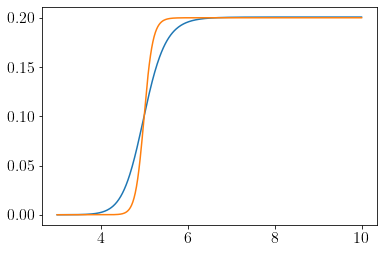

In [41]:
@njit
def butterworth_njit(m1, m0, eta):
    y=(1+ (m0/m1)**eta)**(-1)
    norm = integrate_trap_njit(y, m1)
    return (1+ (m0/m1)**eta)**(-1) / norm

# # Test block
m1 = np.linspace(3.0, 10.0, 500)
plt.plot(m1, butterworth_njit(m1, 5.0, 20.0))
plt.plot(m1, butterworth_njit(m1, 5.0, 50.0))

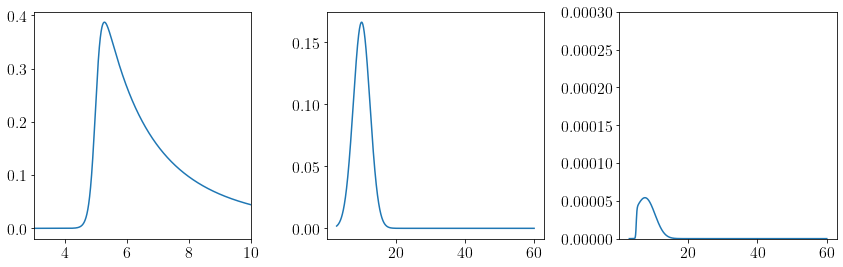

In [42]:
# Visualize the defined functions for sanity

m_min=5
m_max=60
eta = 50.0

alpha = -3.5
m_min_lim = 3.0
m1 = np.geomspace(m_min_lim, m_max, 100000)

pdf_m1 = butterworth_njit(m1, m_min, eta) * power(m1, alpha, m_min_lim, m_max)
pdf_m1 = pdf_m1/integrate.trapezoid(pdf_m1, m1)

mu = 10.2
sigma = 2.4
alpha=-3.5

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax1.plot(m1, pdf_m1)
ax1.set_xlim(3, 10)
ax2.plot(m1, normal_dist(m1, mu, sigma))
# ax2.set_xlim(0, 20)
ax3.plot(m1, (butterworth_njit(m1, m_min, eta) * power(m1, alpha, m_min_lim, m_max)* normal_dist(m1, mu, sigma)))

plt.ylim(0, 0.0003)

plt.tight_layout()
plt.show()


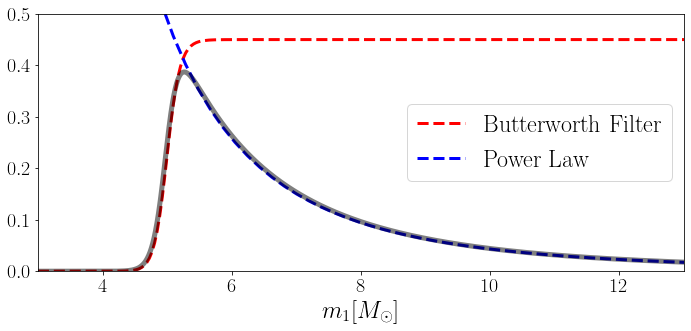

In [57]:

m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=False, bias_index=bias_index)
bins = np.geomspace(m_min_lim_inj, 80, 80)

y, X = np.histogram(m1_mu_sampled, bins=bins, density=True)
X = X[:-1]

m1 = np.geomspace(m_min_lim_inj, mmax_inj, 100000)
pdf_m1 = butterworth_njit(m1, mmin_inj, eta_inj) * power(m1, alpha_inj, m_min_lim_inj, mmax_inj)
pdf_m1 = pdf_m1/integrate.trapezoid(pdf_m1, m1)
# plt.plot(X, y)
# plt.loglog()

plt.figure(figsize=(10, 5))

x1 = np.linspace(m_min_lim_inj, 15, 300)
plt.plot(x1 , 4.5*butterworth_njit(x1 , mmin_inj, eta_inj), c='r', lw=3, linestyle='--', label='Butterworth Filter')

x2 = np.linspace(m_min_lim_inj, mmax_inj, 300)
plt.plot(x2 , 3.5*power(x2 , alpha_inj, m_min_lim_inj, mmax_inj), c='b', lw=3, linestyle='--', label='Power Law')

plt.plot(m1, pdf_m1, c='k', lw=5, alpha=0.5)

# plt.plot(X, y, 'ro', label='Data')
plt.xlabel("$m_1 [M_\odot]$", fontsize=24)
plt.legend(fontsize=24)

plt.xlim(3.0, 13.0)
plt.ylim(0.0, 0.5)

plt.tight_layout()
plt.savefig('1D_bias_plots/powerlaw_pop.pdf', dpi=300)
plt.show()


(2.0, 20.0)

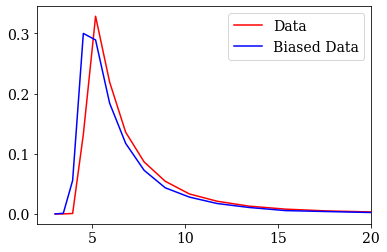

In [16]:
bins = np.geomspace(m_min_lim_inj, 60, 23)

mass1, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=False, bias_index=bias_index)


y, X = np.histogram(mass1, bins=bins, density=True)
X = X[:-1]

plt.plot(X, y, 'r', label='Data')



mass1, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=True, bias_index=bias_index)
y, X = np.histogram(mass1, bins=bins, density=True)
X = X[:-1]

plt.plot(X, y, 'b', label='Biased Data')

plt.legend()
# plt.loglog()
plt.xlim(2, 20)


In [17]:
np.sum(m1_mu_sampled < 5.0)

341

# Main Log-Likelihood Function

## Numba Attempt

In [18]:
# Numba attempt

def compute_log_likelihood(hyper, n_m1_int, n_m2_int, m1_mu_events, m2_mu_events, covariances):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]
    m_min_lim = hyper[3]
    eta = hyper[4]
    beta = hyper[5]

    Nt = len(m1_mu_events)    

    integrand_m2 = np.zeros((Nt, n_m1_int))

    m1_int_range = np.geomspace(m_min_lim, m1_max_pow, n_m1_int)
    
    prior_m1 = butterworth_njit(m1_int_range, m1_min_pow, eta) * power(m1_int_range, alpha, m_min_lim, m1_max_pow)
    prior_m1 = prior_m1 / integrate_trap_njit(prior_m1, m1_int_range)

    
    for j in range(1,n_m1_int):
        m2_int_range = np.geomspace(m_min_lim, m1_int_range[j], n_m2_int)
        prior_m2 = power(m2_int_range, beta, m_min_lim, m1_int_range[j])
        norm_p2 = integrate_trap_njit(prior_m2, m2_int_range)
        if norm_p2 != 0:
            prior_m2 = prior_m2/norm_p2

        for i in range(Nt):
            posteriors_m2 = bivariate_normal_dist_njit(m1_int_range[j], m2_int_range, m1_mu_events[i], m2_mu_events[i], covariances[i][0,0], covariances[i][0,1], covariances[i][1,1])
            integrand_m2[i,j] = integrate_trap_njit(prior_m2 * posteriors_m2, m2_int_range)
    
    integrands = prior_m1 * integrand_m2
    integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)

    integrals = integrals[integrals!=0]
    return np.sum(np.log(integrals))



## Default Version

In [17]:
# def compute_log_likelihood(hyper, n_m1_int, n_m2_int, m1_mu_events, m2_mu_events, covariances):
#     alpha = hyper[0]
#     m1_min_pow = hyper[1]
#     m1_max_pow = hyper[2]
#     m_min_lim = hyper[3]
#     eta = hyper[4]
#     beta = hyper[5]

#     Nt = len(m1_mu_events)    

#     integrand_m2 = np.zeros((Nt, n_m1_int))

#     m1_int_range = np.geomspace(m_min_lim, m1_max_pow, n_m1_int)
    
#     prior_m1 = butterworth(m1_int_range, m1_min_pow, eta) * power(m1_int_range, alpha, m_min_lim, m1_max_pow)
#     prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m1_int_range)
    
#     for j in range(n_m1_int):
#         m2_int_range = np.geomspace(m_min_lim, m1_int_range[j], n_m2_int)
#         prior_m2 = power(m2_int_range, beta, m_min_lim, m1_int_range[j])
#         norm_p2 = integrate.trapezoid(prior_m2, m2_int_range)
#         if norm_p2 != 0:
#             prior_m2 = prior_m2/norm_p2

#         for i in range(Nt):
#             posteriors_m2 = bivariate_normal_dist(m1_int_range[j], m2_int_range, m1_mu_events[i], m2_mu_events[i], covariances[i])
#             integrand_m2[i,j] = integrate.trapezoid(prior_m2 * posteriors_m2, m2_int_range)
    

#     integrands = prior_m1 * integrand_m2
#     integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)

#     integrals = integrals[integrals!=0]
#     return np.sum(np.log(integrals))



# Compute 1D Hyper posterior

In [142]:
def get_cofidence_int_1d(log_norm, range):
    # 68% confidence interval using KDE
    cdf_likelihood = integrate.cumulative_trapezoid(np.exp(log_norm), range, initial=0)
    cdf_likelihood = cdf_likelihood/np.max(cdf_likelihood)

    # make sure the cdf is strictly increasing to interpolate
    index_min = np.where(cdf_likelihood == np.min(cdf_likelihood))[0][0]
    index_max = np.where(cdf_likelihood == np.max(cdf_likelihood))[0][0]

    inv_cdf_interp = interpolate.interp1d(cdf_likelihood[index_min:index_max], range[index_min:index_max], fill_value="extrapolate")


    med = inv_cdf_interp(0.5)
    sig_pos = inv_cdf_interp(0.84)
    sig_neg = inv_cdf_interp(0.16)

    return med, sig_pos, sig_neg

## $\alpha$ hyper-posterior

### $\lambda$=0, alpha posterior

In [26]:
save_likelihoods = True

In [33]:
# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [259]:
alpha_min = alpha_inj-.25
alpha_max=alpha_inj+.25
n_alpha=40

alpha_range_lam_0 = np.linspace(alpha_min, alpha_max, n_alpha)
fname_alpha_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_log_likelihoods_lam_0"    

In [35]:
start = time.time()

log_p_alpha_lam_0_src = np.zeros(n_alpha)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for a in range(n_alpha):
    hyper[0] = alpha_range_lam_0[a]
    log_p_alpha_lam_0_src[a] = compute_log_likelihood(hyper, n_m1_int=300, n_m2_int=300, \
                                                     m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_alpha_norm_lam_0 =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_alpha_lam_0, log_alpha_norm_lam_0)

end = time.time()
print(f"computation completed in {end-start:.3f} s")

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


computation completed in 724.894 s


In [260]:
# Load likelihoods from file
log_alpha_norm_lam_0 = np.loadtxt(fname_alpha_lam_0)

In [261]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm_lam_0, alpha_range_lam_0)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.458908664832748, -3.430900231050965, -3.403521286950826
Injected alpha is 2.524 sigma away


most likely alpha (IN SOURCE FRAME) = -3.430900231050965


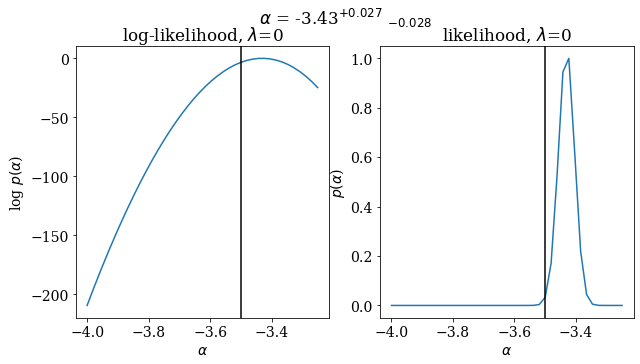

In [262]:
print("most likely alpha (IN SOURCE FRAME) =",med_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_lam_0, log_alpha_norm_lam_0)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(alpha_range_lam_0, np.exp(log_alpha_norm_lam_0))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda$=1, alpha posterior

In [271]:
save_likelihoods = True

In [272]:
# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=True, bias_index=bias_index)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [277]:
alpha_min = alpha_inj-1.5
alpha_max=alpha_inj+0.5
n_alpha=30

alpha_range_lam_1 = np.linspace(alpha_min, alpha_max, n_alpha)
fname_alpha_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_log_likelihoods_lam_0"    

In [278]:
log_p_alpha_lam_1_src = np.zeros(n_alpha)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for a in range(n_alpha):
    hyper[0] = alpha_range_lam_1[a]
    log_p_alpha_lam_1_src[a] = compute_log_likelihood(hyper, n_m1_int=300, n_m2_int=300, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_alpha_norm_lam_1 =log_p_alpha_lam_1_src - np.max(log_p_alpha_lam_1_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_alpha_lam_1, log_alpha_norm_lam_1)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [279]:
# Load likelihoods from file
# log_alpha_norm_lam_1 = np.loadtxt(fname_alpha_lam_1)

In [280]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm_lam_1, alpha_range_lam_1)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.9424726798565333, -3.889209862683112, -3.8408313284943505
Injected alpha is -8.045 sigma away


most likely alpha (IN SOURCE FRAME) = -3.889209862683112


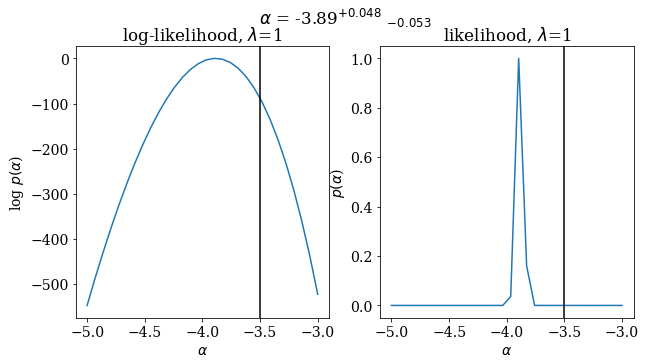

In [281]:
print("most likely alpha (IN SOURCE FRAME) =",med_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_lam_1, log_alpha_norm_lam_1)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(alpha_range_lam_1, np.exp(log_alpha_norm_lam_1))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior_lam_1.pdf')
plt.show()

## m_min hyper posterior

In [285]:
save_likelihoods = False

In [286]:
# def log_likelihood_mmin_2D(m1_range, m2_range, posteriors,\
#     alpha=-3.5, beta=0.0,\
#     m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
#     m1_max_pow=200., \
#         Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

#     m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros(n_m1_low)

    
#     for m1_low_index in range(n_m1_low):
#         m1_min_pow = m1_low_range[m1_low_index]
        
#         # set the prior on m2
#         prior_m2_full = power(m2_range, beta, m1_min_pow, m1_range[-1])
#         prior_m2 = np.tri(len(m1_range), len(m2_range)) * prior_m2_full
#         norm = integrate.trapezoid(prior_m2, m2_range, axis=1)
#         norm[np.where(norm==0)]=1.0
#         prior_m2 = prior_m2 / norm[:, np.newaxis]

#         # compute the integral over m2
#         integrals_m2 = np.zeros((len(posteriors), len(m1_range)))
#         for i in range(len(posteriors)): 
#             integrals_m2[i] = np.sum(np.dot(prior_m2 , np.transpose(posteriors[i])), axis=0)

#         # # try without m2 prior
#         # integrals_m2 = np.zeros((len(posteriors), len(m1_range)))
#         # for i in range(len(posteriors)):
#         #     integrals_m2[i] = integrate.trapezoid(posteriors[0], m2_range, axis=1)

#         # set the prior on m1
#         prior_m1 = power(m1_range, alpha, m1_min_pow, m1_max_pow)
#         prior_m1 = prior_m1 / integrate.trapezoid(prior_m1, m1_range)

#         # compute the integral over m1
#         m1_integrand = prior_m1 * integrals_m2
#         log_likelihoods[m1_low_index] = np.sum(np.log(integrate.trapezoid(m1_integrand, m1_range, axis=1)))
        
        
#     return log_likelihoods, m1_low_range

### $\lambda=0$, m_min posterior

In [287]:
# set the required data (takes ~ 1 min for 1000 events)
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=False)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [288]:
m1_low_min = 4.7
m1_low_max = 5.3
n_m1_low = 10

m1_low_range_lam_0 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
fname_mmin_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_0"    

In [289]:
log_p_mmin_lam_0_src = np.zeros(n_m1_low)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for m in range(n_m1_low):
    hyper[1] = m1_low_range_lam_0[m]
    log_p_mmin_lam_0_src[m] = compute_log_likelihood(hyper, n_m1_int=800, n_m2_int=400, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_mmin_norm_lam_0 =log_p_mmin_lam_0_src - np.max(log_p_mmin_lam_0_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_mmin_lam_0, log_mmin_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [27]:
# Load likelihoods from file
# log_mmin_norm_lam_0 = np.loadtxt(fname_mmin_lam_0)

In [300]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_0, m1_low_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")

68% Confidence interval: 4.988000004471798, 5.033333347307698, 5.078666680641031
Injected mmin is 0.735 sigma away


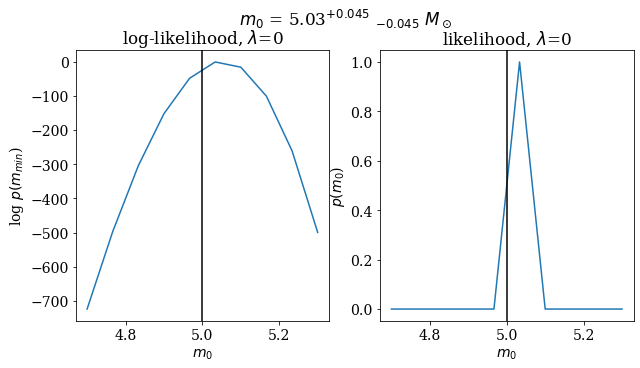

In [301]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_0, log_mmin_norm_lam_0)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{0}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_low_range_lam_0, np.exp(log_mmin_norm_lam_0))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("$p(m_{0}$)")
axes[1].set_xlabel("$m_{0}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$m_0$ = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_detections)}_mmin_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, m_min posterior

In [290]:
save_likelihoods = False

In [302]:
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=True, bias_index=bias_index)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [303]:
m1_low_min = 4.5
m1_low_max = 4.8
n_m1_low = 20

m1_low_range_lam_1 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
fname_mmin_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_1"    

In [304]:
log_p_mmin_lam_1_src = np.zeros(n_m1_low)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for m in range(n_m1_low):
    hyper[1] = m1_low_range_lam_1[m]
    log_p_mmin_lam_1_src[m] = compute_log_likelihood(hyper, n_m1_int=500, n_m2_int=400, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_mmin_norm_lam_1 =log_p_mmin_lam_1_src - np.max(log_p_mmin_lam_1_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_mmin_lam_1, log_mmin_norm_lam_1)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [305]:
# Load likelihoods from file
# log_mmin_norm_lam_1 = np.loadtxt(fname_mmin_lam_1)

In [306]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_1, m1_low_range_lam_1)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")

68% Confidence interval: 4.675678762304474, 4.68712054001001, 4.700138201081323
Injected mmin is -24.035 sigma away


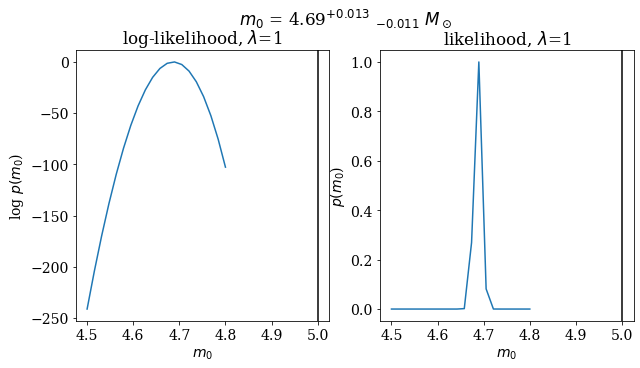

In [307]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_1, log_mmin_norm_lam_1)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{0}$)")
axes[0].set_xlabel("$m_{0}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_low_range_lam_1, np.exp(log_mmin_norm_lam_1))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("$p(m_{0}$)")
axes[1].set_xlabel("$m_{0}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$m_0$ = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_detections)}_mmin_hyper_posterior_lam_1.pdf')
plt.show()

## m_max hyper-posterior

### $\lambda=0$, m_max posterior

In [173]:
save_likelihoods = False

In [46]:
# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [47]:
print(np.max(m1_mu_sampled))

58.659736216954165


In [48]:
m1_high_min = mmax_inj - 20.
m1_high_max= mmax_inj + 30.
n_m1_high=10

m1_high_range_lam_0 = np.linspace(m1_high_min, m1_high_max, n_m1_high)
fname_mmax_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmax_{m1_high_min:.2f}_{m1_high_max:.2f}_n_{n_m1_high:.0f}_log_likelihoods_lam_0"    

In [49]:
log_p_mmax_lam_0_src = np.zeros(n_m1_high)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for m in range(n_m1_high):
    hyper[2] = m1_high_range_lam_0[m]
    log_p_mmax_lam_0_src[m] = compute_log_likelihood(hyper, n_m1_int=800, n_m2_int=400, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_mmax_norm_lam_0 =log_p_mmax_lam_0_src - np.max(log_p_mmax_lam_0_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_mmax_lam_0, log_mmax_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [50]:
# # Load likelihoods from file
# log_mmax_norm_lam_0 = np.loadtxt(fname_mmax_lam_0)

In [51]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm_lam_0, m1_high_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmax is {bias_sigma:.3f} sigma away")


68% Confidence interval: 80.60498705058575, 84.40773038725342, 88.2104737239211
Injected mmax is 6.418 sigma away


most likely m1_max (IN SOURCE FRAME) = 84.40773038725342


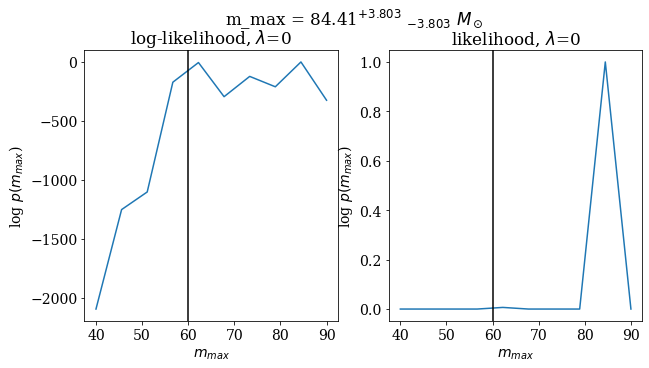

In [52]:
print("most likely m1_max (IN SOURCE FRAME) =",med_mmax)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_lam_0, log_mmax_norm_lam_0)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_high_range_lam_0, np.exp(log_mmax_norm_lam_0))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, m_max posterior

In [174]:
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:200], df_eta[:200], injected=True, biased=True, bias_index=bias_index)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [180]:
m1_high_min = mmax_inj - 40.0
m1_high_max= mmax_inj + 40.
n_m1_high = 10

m1_high_range_lam_1 = np.linspace(m1_high_min, m1_high_max, n_m1_high)
fname_mmax_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_mmax_{m1_high_min:.2f}_{m1_high_max:.2f}_n_{n_m1_high:.0f}_log_likelihoods_lam_1"    

In [181]:
log_p_mmax_lam_1_src = np.zeros(n_m1_high)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for m in range(n_m1_high):
    hyper[2] = m1_high_range_lam_1[m]
    log_p_mmax_lam_1_src[m] = compute_log_likelihood(hyper, n_m1_int=800, n_m2_int=400, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_mmax_norm_lam_1 =log_p_mmax_lam_1_src - np.max(log_p_mmax_lam_1_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_mmax_lam_1, log_mmax_norm_lam_1)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [182]:
# # Load likelihoods from file
# log_mmax_norm_lam_1 = np.loadtxt(fname_mmax_lam_1)

In [183]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm_lam_1, m1_high_range_lam_1)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmax is {bias_sigma:.3f} sigma away")


68% Confidence interval: 26.91400116832169, 37.76743931283116, 70.18609837953025
Injected mmax is -0.686 sigma away


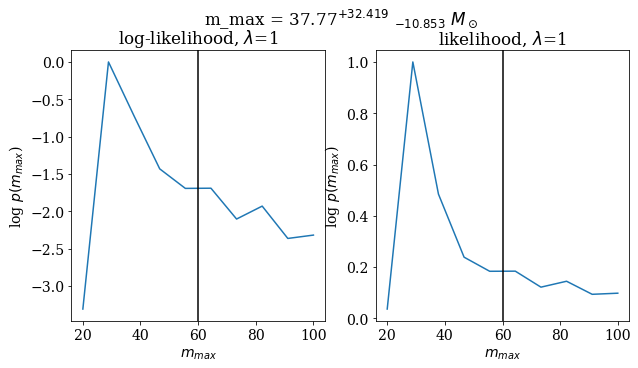

In [184]:
# print(f"most likely m1_max (IN SOURCE FRAME) = {m1_high_range_lam_1[np.argmax(log_mmax_norm_lam_1)]:.3f}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_lam_1, log_mmax_norm_lam_1)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_high_range_lam_1, np.exp(log_mmax_norm_lam_1))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

## eta hyper-posterior

### $\lambda=0$, $\eta$ posterior

In [151]:
save_likelihoods = True

In [153]:
# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [154]:
m1_eta_min = eta_inj - 20.
m1_eta_max= eta_inj + 90.
n_m1_eta= 40

m1_eta_range_lam_0 = np.linspace(m1_eta_min, m1_eta_max, n_m1_eta)
fname_eta_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_eta_{m1_eta_min:.2f}_{m1_eta_max:.2f}_n_{n_m1_eta:.0f}_log_likelihoods_lam_0"    

In [155]:
log_p_eta_lam_0_src = np.zeros(n_m1_eta)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for m in range(n_m1_eta):
    hyper[4] = m1_eta_range_lam_0[m]
    log_p_eta_lam_0_src[m] = compute_log_likelihood(hyper, n_m1_int=2000, n_m2_int=300, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_eta_norm_lam_0 =log_p_eta_lam_0_src - np.max(log_p_eta_lam_0_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_eta_lam_0, log_eta_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [122]:
# # Load likelihoods from file
# log_eta_norm_lam_0 = np.loadtxt(fname_eta_lam_0)

In [159]:
med_eta, sig_pos_eta, sig_neg_eta = get_cofidence_int_1d(log_eta_norm_lam_0, m1_eta_range_lam_0)

print(f"68% Confidence interval: {sig_neg_eta}, {med_eta}, {sig_pos_eta}")
bias_sigma = (med_eta-eta_inj)/(sig_pos_eta-med_eta)
print(rf"Injected eta is {bias_sigma:.3f} sigma away")

68% Confidence interval: 75.26773216272358, 81.48453391041238, 88.63358944877372
Injected eta is 4.404 sigma away


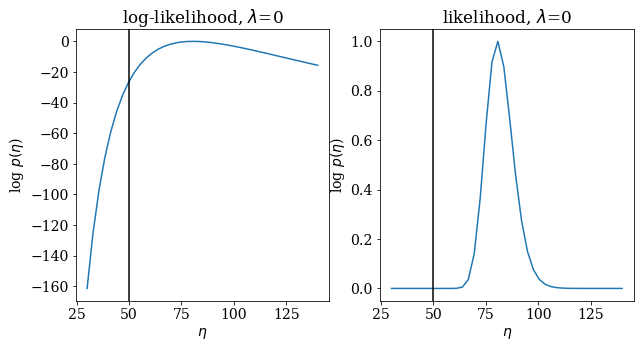

In [160]:
# print("most likely m1_eta (IN SOURCE FRAME) =",med_eta)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_eta_range_lam_0, log_eta_norm_lam_0)
axes[0].axvline(x=eta_inj, color='k')
axes[0].set_ylabel("log $p(\eta$)")
axes[0].set_xlabel("$\eta$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_eta_range_lam_0, np.exp(log_eta_norm_lam_0))
axes[1].axvline(x=eta_inj, color='k')
axes[1].set_ylabel("log $p(\eta$)")
axes[1].set_xlabel("$\eta$")
axes[1].set_title("likelihood, $\lambda$=0")

# plt.suptitle(f"$\eta$ = {med_eta:.2f}$^{{+{sig_pos_eta-med_eta:.3f}}}$ $_{{{sig_neg_eta - med_eta:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_eta_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, $\eta$ posterior

In [176]:
save_likelihoods = True

In [199]:
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:200], df_eta[:200], injected=True, biased=True, bias_index=bias_index)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [200]:
m1_eta_min = eta_inj - 40.
m1_eta_max= eta_inj + 30.
n_m1_eta=30

m1_eta_range_lam_1 = np.linspace(m1_eta_min, m1_eta_max, n_m1_eta)
fname_eta_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_eta_{m1_eta_min:.2f}_{m1_eta_max:.2f}_n_{n_m1_eta:.0f}_log_likelihoods_lam_1"    

In [201]:
log_p_eta_lam_1_src = np.zeros(n_m1_eta)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for m in range(n_m1_eta):
    hyper[4] = m1_eta_range_lam_1[m]
    log_p_eta_lam_1_src[m] = compute_log_likelihood(hyper, n_m1_int=1000, n_m2_int=300, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

log_eta_norm_lam_1 =log_p_eta_lam_1_src - np.max(log_p_eta_lam_1_src)

# Save likelihoods to file
if save_likelihoods:
    np.savetxt(fname_eta_lam_1, log_eta_norm_lam_1)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [202]:
# # Load likelihoods from file
# log_eta_norm_lam_1 = np.loadtxt(fname_eta_lam_1)

In [203]:
med_eta, sig_pos_eta, sig_neg_eta = get_cofidence_int_1d(log_eta_norm_lam_1, m1_eta_range_lam_1)

print(f"68% Confidence interval: {sig_neg_eta}, {med_eta}, {sig_pos_eta}")
bias_sigma = (med_eta-eta_inj)/(sig_pos_eta-med_eta)
print(rf"Injected eta is {bias_sigma:.3f} sigma away")

68% Confidence interval: 14.690194278082203, 17.025557675862025, 19.56806021117567
Injected eta is -12.969 sigma away


most likely m1_eta (IN SOURCE FRAME) = 17.025557675862025


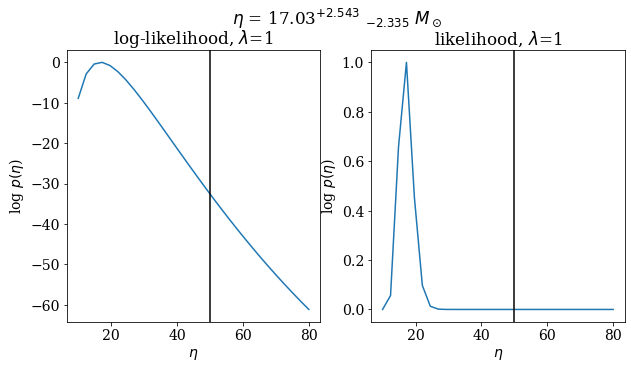

In [204]:
print("most likely m1_eta (IN SOURCE FRAME) =",med_eta)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_eta_range_lam_1, log_eta_norm_lam_1)
axes[0].axvline(x=eta_inj, color='k')
axes[0].set_ylabel("log $p(\eta$)")
axes[0].set_xlabel("$\eta$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_eta_range_lam_1, np.exp(log_eta_norm_lam_1))
axes[1].axvline(x=eta_inj, color='k')
axes[1].set_ylabel("log $p(\eta$)")
axes[1].set_xlabel("$\eta$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\eta$ = {med_eta:.2f}$^{{+{sig_pos_eta-med_eta:.3f}}}$ $_{{{sig_neg_eta - med_eta:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_eta_hyper_posterior_lam_1.pdf')
plt.show()

## beta hyper-posterior

In [ ]:
save_likelihoods=False

### $\lambda=0$, beta posterior

In [308]:
# set the required data 
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [309]:
beta_min = beta_inj-1.25
beta_max = beta_inj+1.25

n_beta = 30

beta_range_lam_0 = np.linspace(beta_min, beta_max, n_beta)
fname_beta_lam_0 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_beta_{beta_min:.2f}_{beta_max:.2f}_n_{n_beta:.0f}_log_likelihoods_lam_0"    

In [134]:
log_p_beta_lam_0_src = np.zeros(n_beta)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for b in range(n_beta):
    hyper[5] = beta_range_lam_0[b]
    log_p_beta_lam_0_src[b] = compute_log_likelihood(hyper, n_m1_int=500, n_m2_int=300, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)


log_beta_norm_lam_0 = log_p_beta_lam_0_src - np.max(log_p_beta_lam_0_src)

if save_likelihoods:
    np.savetxt(fname_beta_lam_0, log_beta_norm_lam_0)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [310]:
# Load likelihoods from file
log_beta_norm_lam_0 = np.loadtxt(fname_beta_lam_0)

In [311]:
# 68% confidence interval using KDE
med_beta, sig_pos_beta, sig_neg_beta = get_cofidence_int_1d(log_beta_norm_lam_0, beta_range_lam_0)

print(f"68% Confidence interval: {sig_neg_beta}, {med_beta}, {sig_pos_beta}")
bias_sigma = (med_beta-beta_inj)/(sig_pos_beta-med_beta)
print(rf"Injected beta is {bias_sigma:.3f} sigma away")


68% Confidence interval: -0.25953398638169173, -0.18496426456081724, -0.11997229902773653
Injected beta is -2.846 sigma away


most likely beta (IN SOURCE FRAME) = -0.18496426456081724


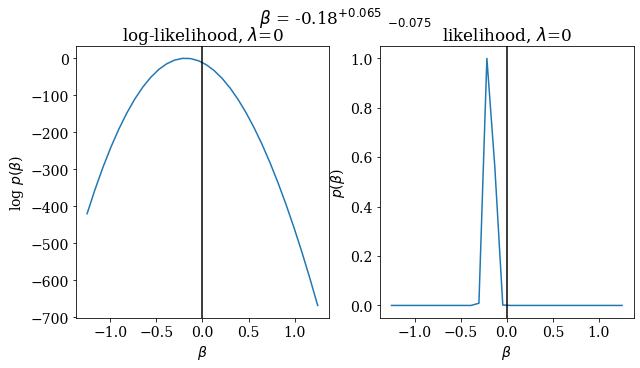

In [312]:
print("most likely beta (IN SOURCE FRAME) =",med_beta)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(beta_range_lam_0, log_beta_norm_lam_0)
axes[0].axvline(x=beta_inj, color='k')
axes[0].set_ylabel("log $p(\\beta$)")
axes[0].set_xlabel("$\\beta$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(beta_range_lam_0, np.exp(log_beta_norm_lam_0))
axes[1].axvline(x=beta_inj, color='k')
axes[1].set_ylabel("$p(\\beta$)")
axes[1].set_xlabel("$\\beta$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$\\beta$ = {med_beta:.2f}$^{{+{sig_pos_beta-med_beta:.3f}}}$ $_{{{sig_neg_beta - med_beta:.3f}}}$", y=0.99)
# plt.tight_layout()

plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_beta_{beta_inj:.1f}_hyper_posterior_lam_0.pdf')
plt.show()

-0.3789, -0.4273

### $\lambda=1$, $\beta$ posterior

In [313]:
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], injected=True, biased=True, bias_index=bias_index)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]

In [314]:
beta_min = beta_inj-2.5
beta_max = beta_inj+5.5
n_beta = 30

beta_range_lam_1 = np.linspace(beta_min, beta_max, n_beta)
fname_beta_lam_1 = f"{likelihood_dir}/N_{len(m1_mu_sampled)}_beta_{beta_min:.2f}_{beta_max:.2f}_n_{n_beta:.0f}_log_likelihoods_lam_1"    

In [315]:
log_p_beta_lam_1_src = np.zeros(n_beta)

hyper = [alpha_inj, mmin_inj, mmax_inj, m_min_lim_inj, eta_inj, beta_inj]

for b in range(n_beta):
    hyper[5] = beta_range_lam_1[b]
    log_p_beta_lam_1_src[b] = compute_log_likelihood(hyper, n_m1_int=500, n_m2_int=300, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)


log_beta_norm_lam_1 = log_p_beta_lam_1_src - np.max(log_p_beta_lam_1_src)

if save_likelihoods:
    np.savetxt(fname_beta_lam_1, log_beta_norm_lam_1)

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [316]:
# 68% confidence interval using KDE
med_beta, sig_pos_beta, sig_neg_beta = get_cofidence_int_1d(log_beta_norm_lam_1, beta_range_lam_1)

print(f"68% Confidence interval: {sig_neg_beta}, {med_beta}, {sig_pos_beta}")
bias_sigma = (med_beta-beta_inj)/(sig_pos_beta-med_beta)
print(rf"Injected beta is {bias_sigma:.3f} sigma away")


68% Confidence interval: 2.2779328543895723, 2.4655229980247597, 2.653109227179019
Injected beta is 13.143 sigma away


most likely beta (IN SOURCE FRAME) = 2.4655229980247597


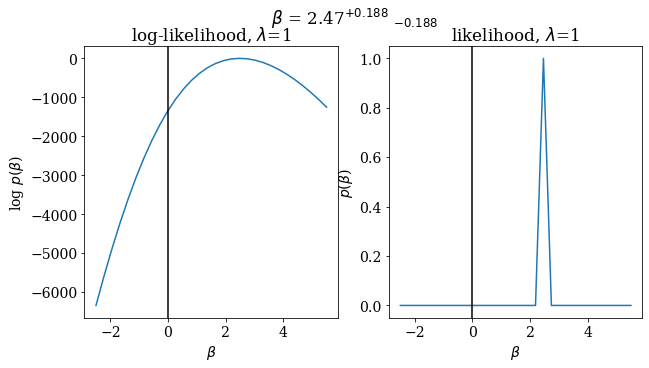

In [317]:
print("most likely beta (IN SOURCE FRAME) =",med_beta)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(beta_range_lam_1, log_beta_norm_lam_1)
axes[0].axvline(x=beta_inj, color='k')
axes[0].set_ylabel("log $p(\\beta$)")
axes[0].set_xlabel("$\\beta$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(beta_range_lam_1, np.exp(log_beta_norm_lam_1))
axes[1].axvline(x=beta_inj, color='k')
axes[1].set_ylabel("$p(\\beta$)")
axes[1].set_xlabel("$\\beta$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\\beta$ = {med_beta:.2f}$^{{+{sig_pos_beta-med_beta:.3f}}}$ $_{{{sig_neg_beta - med_beta:.3f}}}$", y=0.99)
# plt.tight_layout()


# plt.savefig(plotdir+f'N_{len(q_mu_sampled)}_beta_{beta_inj:.1f}_hyper_posterior_lam_1.pdf')
plt.show()

# MCMC

In [19]:
import emcee

In [20]:
m1_mu_sampled, m2_mu_sampled,  m1_variance, m2_variance, m1_m2_covariance = sample_m1_m2_events(df_mc[:], df_eta[:], biased=False, bias_index=bias_index, injected=True)
covariances = np.zeros((len(m1_mu_sampled), 2,2))

for i in range(len(m1_mu_sampled)):
    covariances[i] =  [[m1_variance[i], m1_m2_covariance[i]], [m1_m2_covariance[i], m2_variance[i]]]
print(m1_mu_sampled[:5])

[6.97429615 4.83770957 6.82063104 6.41273859 5.35827628]


In [22]:
np.max(m1_mu_sampled)

58.659736216954165

In [23]:
def population_posterior(hyper):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]
    # m_min_lim = m_min_lim_inj
    eta = hyper[3]
    beta = hyper[4]

    if (alpha>-2.0) or (alpha<-6.0):
        return -np.inf
    if (m1_min_pow>6.5) or (m1_min_pow<3.0):
        return -np.inf
    if (m1_max_pow>100.0) or (m1_max_pow<10.0):
        return -np.inf
    if (eta>120.0) or (eta<10.0):
        return -np.inf
    if (beta>5.0) or (beta<-1.0):
        return -np.inf
    
    else:
        hyper_mcmc =  [alpha, m1_min_pow, m1_max_pow, m_min_lim_inj, eta, beta]
        return compute_log_likelihood(hyper_mcmc, n_m1_int=300, n_m2_int=300, \
                                                      m1_mu_events=m1_mu_sampled, m2_mu_events=m2_mu_sampled, covariances=covariances)

In [28]:
hyper_test = [-3.5, 4.97, 61.4, 50.0, 0.0]

start = time.time()
print(population_posterior(hyper_test))
end = time.time()

print(f"Time: {end-start:.5f} s")

-37407.684675913864
Time: 13.64918 s


In [30]:
ndim, nwalkers = 5, 11

N_events = len(m1_mu_sampled)
mcmc_file = likelihood_dir  + f'N_events_{N_events}_N_walkers_{nwalkers}_biased.h5'

backend = emcee.backends.HDFBackend(mcmc_file)
# backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, backend=backend)

p0 = np.random.uniform([-3.4, 4.99, 45, 40.0, -0.05], [-3.6, 5.01, 55, 60.0, 0.05], size=(nwalkers,ndim))
# p0 = np.random.uniform([-4.2, 4.99], [-3.8, 5.01], size=(nwalkers,ndim))

# # To CONTINUE MCMC run:
# state = sampler.run_mcmc(None, 5, progress=True)

# For NEW MCMC run:
# burn-in sampler:
state = sampler.run_mcmc(p0, 5, progress=True)
sampler.reset()


100%|██████████| 5/5 [12:39<00:00, 151.85s/it]


In [32]:
N_MCMC = 50

# explore parameter space:
state = sampler.run_mcmc(state, N_MCMC, progress=True)

100%|██████████| 50/50 [2:28:28<00:00, 178.16s/it]


In [211]:
N_MCMC = 5000

# explore parameter space:
state = sampler.run_mcmc(state, N_MCMC, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
100%|██████████| 5000/5000 [6:05:58<00:00,  4.39s/it]  


In [33]:
# get flat results:
flat_samples = sampler.get_chain(discard=5, flat=True)

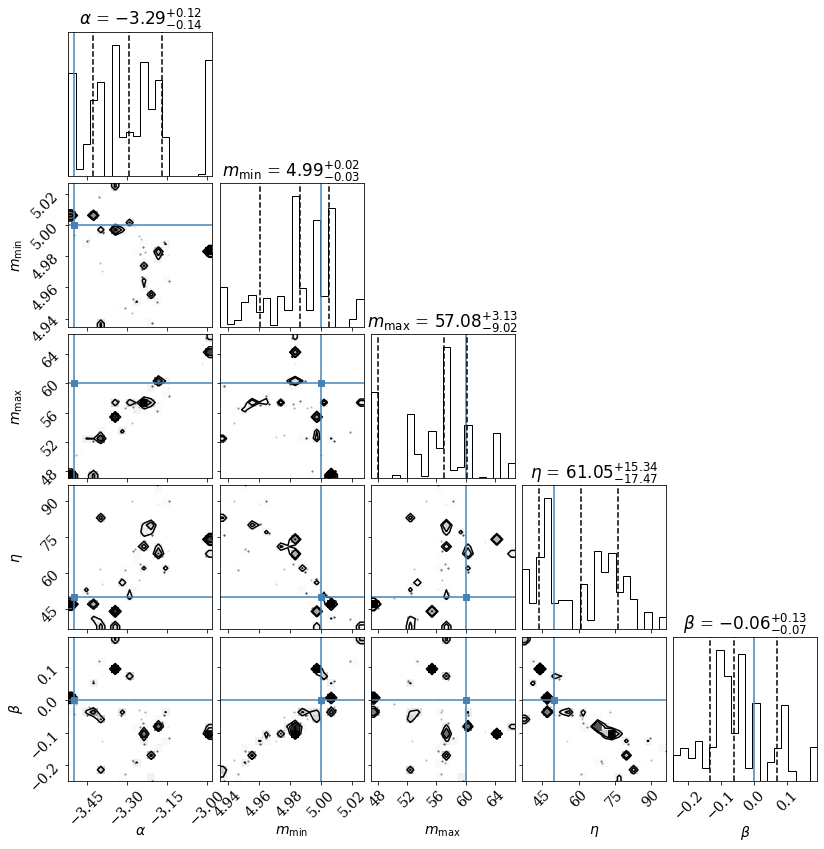

In [34]:
fig = corner.corner(flat_samples, truths=[alpha_inj, mmin_inj, mmax_inj, eta_inj, beta_inj],\
                    labels=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$", r"$\eta$", r"$\beta$"],\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True,)

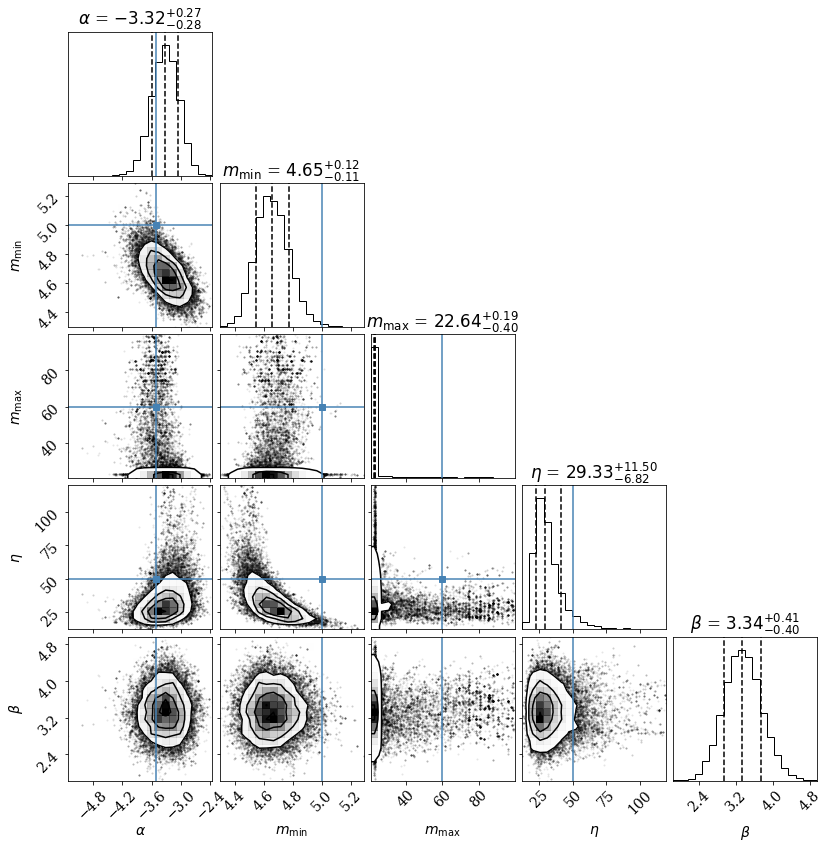

In [240]:

fig = corner.corner(flat_samples, truths=[alpha_inj, mmin_inj, mmax_inj, eta_inj, beta_inj],\
                    labels=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$", r"$\eta$", r"$\beta$"],\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True,)


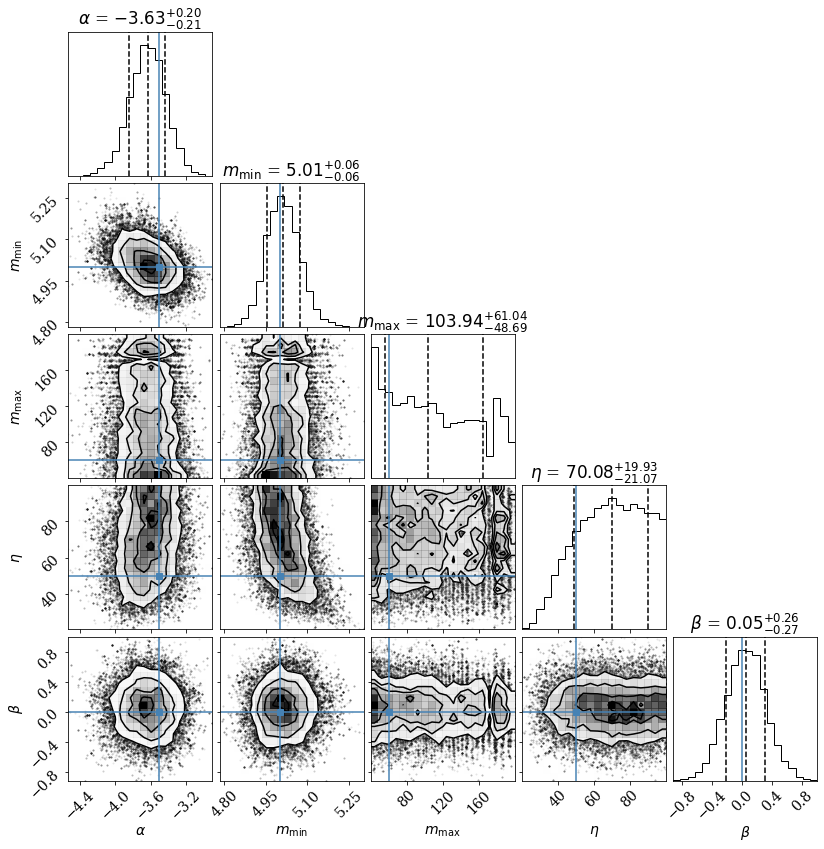

In [53]:
# samples

fig = corner.corner(flat_samples, truths=[alpha_inj, mmin_inj, mmax_inj, eta_inj, beta_inj],\
                    labels=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$", r"$\eta$", r"$\beta$"],\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True,)

# fig = corner.corner(flat_samples, truths=[alpha_inj, mmin_inj, mmax_inj],\
                    # labels=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$"],\
                    #     quantiles=[0.16, 0.5, 0.84],\
                    #         show_titles=True,)
plt.savefig(plotdir + f"N_events_200_N_MCMC_{N_MCMC}.pdf")

In [50]:
samples = sampler.chain[:, 5:, :].reshape((-1, ndim))

alpha_mcmc, mmin_mcmc, mmax_mcmc, eta_mcmc, beta_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(alpha_mcmc)
print(mmin_mcmc)
print(mmax_mcmc)
print(eta_mcmc)
print(beta_mcmc)

(-3.6332091823354014, 0.19785079126178085, 0.20928925399716247)
(5.010467560891885, 0.06242979761641454, 0.05760729553259125)
(103.66343767650017, 61.24919077519712, 48.51777785598403)
(69.98863963561627, 19.965852037774795, 20.95116949291331)
(0.04907815934563027, 0.2559843863409009, 0.2686348815675662)
